In [4]:
from tsai.models import InceptionTime, TST, ResNet
# from tsai.data.core import get_UCR_data
# from tsai.learner import TSClassifier
import os
import numpy as np
import sys
print(sys.executable)
import sys
sys.path.insert(1, '../src/')
from CNN_classifier_model import CNNClassifier, train_model, evaluate_model
from config import raw_data_path, univariate_data_path, processed_data_path
from preprocessing_modules import create_time_windows_with_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import wandb
wandb.login(key="5f15eb7efc1e0e939ccc83345338a0b8c24e2fbc")
from fastai.data.core import DataLoaders



wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/nwertheim/.netrc


/home/nwertheim/miniconda3/bin/python


In [9]:
'''MY DATA + class weights'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_test.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight
from fastai.losses import CrossEntropyLossFlat

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)

# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
# Create DataLoaders
batch_size = 32

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap your DataLoaders and set device
dls = DataLoaders.from_dsets(
    train_dataset,
    test_dataset,
    bs=32,
    shuffle=True,
    num_workers=0  # avoid multiprocessing issues
)

744
192
{'record_name': 'Hopper-2024_09_17_06_51_03-0000010009-0001-chan0', 'signal': array([[ -5.57103828],
       [-11.39992725],
       [ -9.53483776],
       ...,
       [  0.73235611],
       [ -0.1656677 ],
       [  1.35035514]]), 'fs': 20, 'preterm': 0}
Train label distribution:
  Term (0): 3360
  Preterm (1): 5748

Test label distribution:
  Term (0): 390
  Preterm (1): 2322
torch.Size([9108])


In [12]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, roc_auc_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from tsai.models.ResNet import ResNet
from fastai.learner import Learner
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import torch


# Fix seeds for reproducibility
def seed_everything(seed):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

num_runs = 5
all_train_losses = []
all_valid_losses = []
all_metrics = []

best_ap = -1
best_preds = None
best_targs = None

for run in range(num_runs):
    print(f"\n🌀 Run {run+1}/{num_runs}")
    seed_everything(run)

    # Model
    model = ResNet(1, 2).to(device)

    # Loss with class weights
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    loss_func = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Learner
    learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy)
    learn.model.to(device)
    learn.dls.to(device)

    # Fit
    learn.fit_one_cycle(5, 1e-5)

    # Record losses
    losses = np.array(learn.recorder.losses)
    iters_per_epoch = len(train_loader)
    train_loss = losses[::2][:5]
    valid_loss = losses[1::2][:5]
    all_train_losses.append(train_loss)
    all_valid_losses.append(valid_loss)

    # Get predictions
    preds, targs = learn.get_preds(dl=learn.dls.valid)
    pred_labels = preds.argmax(dim=1)
    pred_probs = preds[:, 1].cpu().numpy()
    true_labels = targs.cpu().numpy()
    pred_labels_np = pred_labels.cpu().numpy()

    # Metrics
    acc = accuracy_score(true_labels, pred_labels_np)
    prec = precision_score(true_labels, pred_labels_np, zero_division=0)
    rec = recall_score(true_labels, pred_labels_np, zero_division=0)
    f1 = f1_score(true_labels, pred_labels_np, zero_division=0)
    ap = average_precision_score(true_labels, pred_probs)
    auc = roc_auc_score(true_labels, pred_probs)
    all_metrics.append([acc, prec, rec, f1, ap, auc])

    if ap > best_ap:
        best_ap = ap
        best_preds = pred_labels_np
        best_targs = true_labels

# Convert to arrays for easy processing
all_train_losses = np.stack(all_train_losses)
all_valid_losses = np.stack(all_valid_losses)
all_metrics = np.stack(all_metrics)



🌀 Run 1/5


epoch,train_loss,valid_loss,accuracy,time



🌀 Run 2/5


epoch,train_loss,valid_loss,accuracy,time
0,0.687827,0.669209,0.693584,00:15
1,0.684135,0.700916,0.573378,00:15
2,0.684293,0.707388,0.566740,00:15
3,0.676826,0.694539,0.584808,00:15
4,0.680421,0.669604,0.644912,00:15



🌀 Run 3/5


epoch,train_loss,valid_loss,accuracy,time
0,0.688860,0.676737,0.676622,00:15
1,0.686206,0.680154,0.675885,00:15
2,0.683325,0.668137,0.694322,00:15
3,0.677724,0.691724,0.630900,00:15
4,0.680726,0.685432,0.648230,00:15



🌀 Run 4/5


epoch,train_loss,valid_loss,accuracy,time
0,0.685795,0.669210,0.697271,00:15
1,0.686961,0.680809,0.667773,00:15
2,0.687458,0.680568,0.694690,00:15
3,0.685444,0.679170,0.695059,00:15
4,0.685366,0.682935,0.683260,00:15



🌀 Run 5/5


epoch,train_loss,valid_loss,accuracy,time
0,0.688722,0.684040,0.676622,00:15
1,0.685610,0.663247,0.702802,00:15
2,0.682202,0.680598,0.656342,00:15
3,0.677587,0.671954,0.671460,00:15
4,0.678964,0.689074,0.628319,00:15


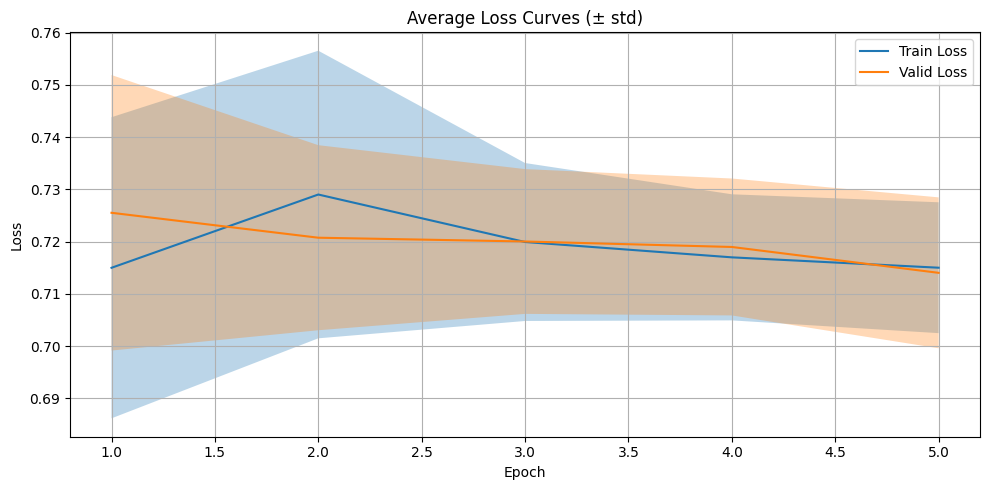

In [13]:
epochs = np.arange(1, 6)
plt.figure(figsize=(10, 5))

# Train loss
mean_train = all_train_losses.mean(axis=0)
std_train = all_train_losses.std(axis=0)
plt.plot(epochs, mean_train, label='Train Loss')
plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, alpha=0.3)

# Valid loss
mean_valid = all_valid_losses.mean(axis=0)
std_valid = all_valid_losses.std(axis=0)
plt.plot(epochs, mean_valid, label='Valid Loss')
plt.fill_between(epochs, mean_valid - std_valid, mean_valid + std_valid, alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Curves (± std)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Accuracy: 0.6592 ± 0.0241
Precision: 0.9247 ± 0.0158
Recall: 0.6555 ± 0.0252
F1 Score: 0.7669 ± 0.0189
AP: 0.9254 ± 0.0642
AUC: 0.6875 ± 0.1594


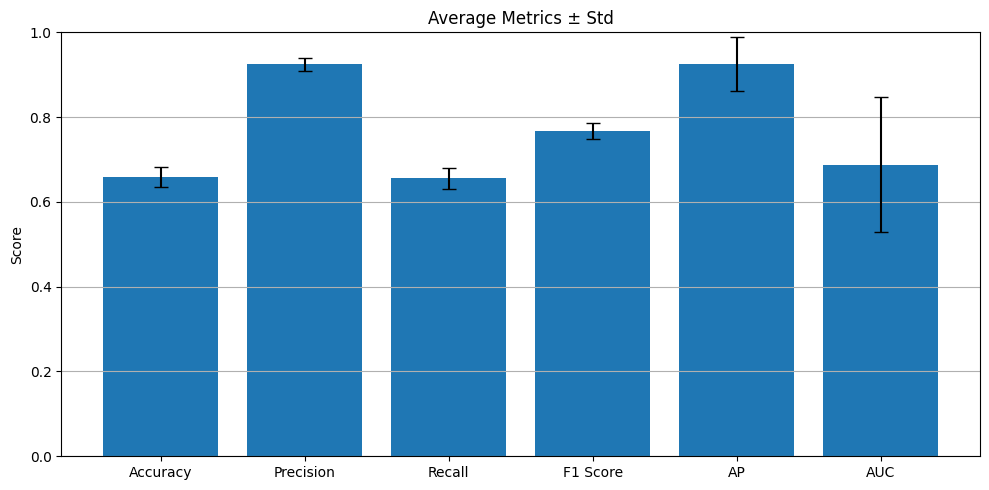

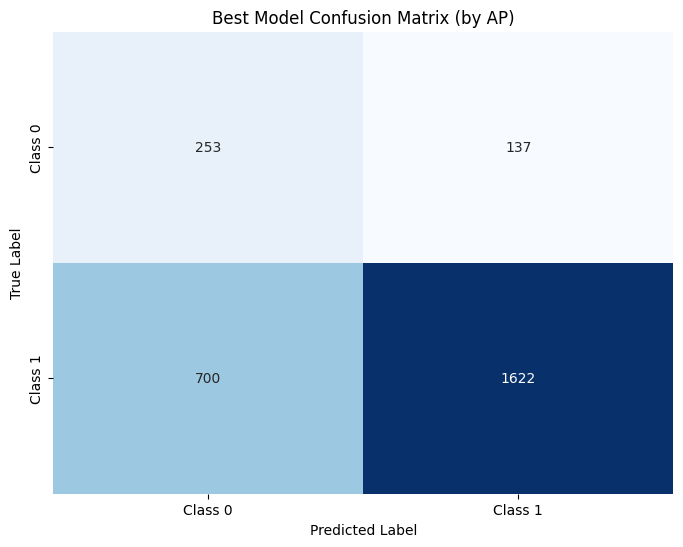

In [14]:
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AP', 'AUC']
mean_metrics = all_metrics.mean(axis=0)
std_metrics = all_metrics.std(axis=0)

for name, mean, std in zip(metric_names, mean_metrics, std_metrics):
    print(f"{name}: {mean:.4f} ± {std:.4f}")

# Bar plot
plt.figure(figsize=(10, 5))
plt.bar(metric_names, mean_metrics, yerr=std_metrics, capsize=5)
plt.title('Average Metrics ± Std')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

cm = confusion_matrix(best_targs, best_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Best Model Confusion Matrix (by AP)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
